In [2]:
import pandas as pd
import json

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *


In [3]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')

In [3]:
def run_experiment(data, dataset_name: str, current_spot_size: int, third_dim: bool, resolutions: list):
    
    clustering = XeniumCluster(data=data, dataset_name=dataset_name)
    clustering.set_spot_size(current_spot_size)
    clustering.create_spot_data(third_dim=third_dim, save_data=True)

    print(f"The size of the spot data is {clustering.xenium_spot_data.shape}")

    clustering.normalize_counts(clustering.xenium_spot_data)
    clustering.generate_neighborhood_graph(clustering.xenium_spot_data, plot_pcas=False)

    Leiden_cluster = clustering.Leiden(clustering.xenium_spot_data, resolutions, embedding="umap", save_plot=True)
    Louvain_cluster = clustering.Louvain(clustering.xenium_spot_data, resolutions, embedding="umap", save_plot=True)
    hierarchical_cluster = clustering.Hierarchical(clustering.xenium_spot_data, embedding="umap", save_plot=True)

    return Leiden_cluster, Louvain_cluster, hierarchical_cluster

In [10]:
cluster_dict = {}
cluster_results_filepath = "results/clusters.json"

In [6]:
resolutions = [0.05, 1, 2, 0.5]

for spot_size in [100, 75, 50, 25]:
    for third_dim in [False, True]:
        Leiden_cluster, Louvain_cluster, hierarchical_cluster = run_experiment(df_transcripts, "hBreast", spot_size, third_dim, resolutions)
        cluster_dict["Leiden"] = {spot_size: {third_dim: Leiden_cluster}}
        cluster_dict["Louvain"] = {spot_size: {third_dim: Louvain_cluster}}
        cluster_dict["hierarchical"] = {spot_size: {third_dim: hierarchical_cluster.tolist()}}
        print(f"Cluster with spot size {(spot_size, third_dim)} completed.")
        with open(cluster_results_filepath, "w") as f:
            json.dump(cluster_dict, f)

KeyboardInterrupt: 

In [ ]:
cluster_dict = json.load(open(cluster_results_filepath))

The size of the spot data is (7312, 541)


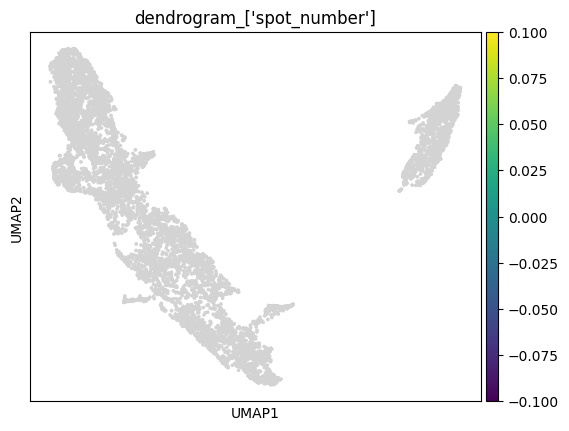

In [11]:
clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
clustering.set_spot_size(100)
clustering.create_spot_data(third_dim=False, save_data=True)

print(f"The size of the spot data is {clustering.xenium_spot_data.shape}")

clustering.normalize_counts(clustering.xenium_spot_data)
clustering.generate_neighborhood_graph(clustering.xenium_spot_data, plot_pcas=False)

hierarchical_cluster = clustering.Hierarchical(clustering.xenium_spot_data, embedding="umap", save_plot=True)

cluster_dict["hierarchical"] = {100: {False: hierarchical_cluster.tolist()}}
with open(cluster_results_filepath, "w") as f:
    json.dump(cluster_dict, f)